In [28]:
%matplotlib inline
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from slab.dsfit import*
from slab import*
import json
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *

def coherent_state(n, alpha):
    return exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def fitgausssum_with_baseline(xdata,ydata,fitparams=None,domain=None,showfit=False,
                              showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def expfunc2(p,x):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*math.e**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc(x,b,c,d):
    """p[0]*exp(-(x-p[1])/p[2])"""
    return b*math.e**(-(x-c)/d) 

def expfunc_test(x,b,c):
    return b * math.e**(-x/c)

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# 100 MHz IF

In [2]:
path = "C:\\_Lib\python\\slab\\experiments\\qm_opx\\data\\"
filename = path + "histogram_amp_freq_sweep_100MHz.h5"
numbins = 200
ran = 0.8
with File(filename,'r') as a:
        Ig = array(a['ig'])/ran
        Qg = array(a['qg'])/ran
        Ie = array(a['ie'])/ran
        Qe = array(a['qe'])/ran
        attens = array(a['att'])
        freqs = array(a['freq'])
        print(shape(Ig))
Ig = pd.DataFrame(Ig)
Qg = pd.DataFrame(Qg)
Ie = pd.DataFrame(Ie)
Qe = pd.DataFrame(Qe)

(2542000,)


In [3]:
len(freqs), len(attens)

(41, 31)

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


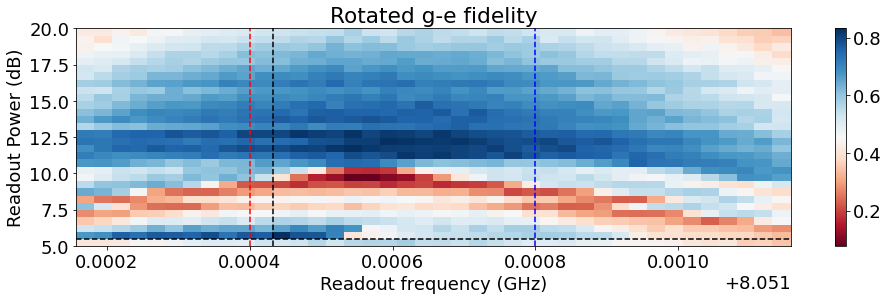

#############################################################################################
Optimal fidelity of 0.832170 at readout power = - 5.500000 dB and readout frequency = 8.051433 GHz
#############################################################################################


In [4]:
fid_power = []
"""The sweep occurs in the following order: for a fixed readout frequency, the power is swept
    and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
    one readout frequency.  
    """
avgs = 2000

for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
#         print(len(ig), len(qe))
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj::len(freqs)]
            b = qg.iloc[jj::len(freqs)]
            c = ie.iloc[jj::len(freqs)]
            d = qe.iloc[jj::len(freqs)]

            """Compute the medians of each blob"""
            
            xg, yg = np.median(a), np.median(b)
            xe, ye = np.median(c), np.median(d)
            
            """Compute the rotation angle"""
            theta = -arctan((ye-yg)/(xe-xg))
            """Rotate the IQ data"""
            ig_new = a*cos(theta) - b*sin(theta)
            qg_new = a*sin(theta) + b*cos(theta) 
            ie_new = c*cos(theta) - d*sin(theta)
            qe_new = c*sin(theta) + d*cos(theta)
#             print(len(ig_new), len(qe_new))

            """New means of each blob"""
            xg, yg = np.median(ig_new), np.median(qg_new)
            xe, ye = np.median(ie_new), np.median(qe_new)
            """X and Y ranges for histogram"""
            xlims = [xg-ran/5, xg+ran/5]
            ylims = [yg-ran/5, yg+ran/5]
#             plt.scatter(ig_new, qg_new, 'bo')
#             plt.scatter(ie_new, qe_new, 'ro')
            
            ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
            ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)
            """Compute the fidelity using overlap of the histograms"""
            fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
            fid_freq.append(fid)
        
        fid_power.append(fid_freq)   
"""Row number corresponding to maximum fidelity"""
# fid_power = np.transpose(fid_power)
ind = np.argmax(fid_power)
f_vec = freqs/1e9 + 0.5*(8.051828 + 8.051487)
plt.figure(figsize=(16, 4))
plt.pcolormesh(f_vec, attens, fid_power, cmap='RdBu')
plt.xlabel('Readout frequency (GHz)')
plt.ylabel('Readout Power (dB)')
plt.title('Rotated g-e fidelity')
plt.colorbar()
plt.axvline(x=f_vec[ind%len(freqs)], color='k', linestyle='--')
plt.axhline(y=attens[ind//len(freqs)], color='k', linestyle='--')
plt.axvline(x = 8.0514, color='r', linestyle='--')
plt.axvline(x = 8.0518, color='b', linestyle='--')
plt.show()

print("#############################################################################################")
print('Optimal fidelity of %f at readout power = - %f dB and readout frequency = %f GHz'%(np.max(fid_power), attens[ind//len(freqs)],f_vec[ind%len(freqs)] ))
print("#############################################################################################")

# ind = ind%len(freqs)*len(attens) + ind//len(freqs)

# ig_opt, qg_opt = Ig.iloc[ind], Qg.iloc[ind]
# ie_opt, qe_opt = Ie.iloc[ind], Qe.iloc[ind]


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.6, right=1.25, top=1.5)

# ax = axs[0, 0]
# ax.set_title('Unrotated')
# ax.scatter(ig_opt, qg_opt, label='g', alpha=0.25)
# ax.scatter(ie_opt, qe_opt, label='e', alpha=0.25)
# xg, yg = mean(ig_opt), mean(qg_opt)
# xe, ye = mean(ie_opt), mean(qe_opt)

# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)

# theta = -arctan((ye-yg)/(xe-xg))
# print("Rotation angle:   %.3f"%theta)

# ax = axs[0, 1]
# ax.set_title('Unrotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.legend(loc='best')
# ax.set_ylim(ylims[0], ylims[1])
# ax.set_xlim(xlims[0], xlims[1])


# ax = axs[1, 0]
# ax.set_title('Rotated')
# ig_new, qg_new = ig_opt*cos(theta)- qg_opt*sin(theta), ig_opt*sin(theta)+ qg_opt*cos(theta) 
# ie_new, qe_new = ie_opt*cos(theta)- qe_opt*sin(theta), ie_opt*sin(theta)+ qe_opt*cos(theta) 

# ax.scatter(ig_new, qg_new, label='g', alpha=0.25)
# ax.scatter(ie_new, qe_new, label='e', alpha=0.25)

# xg, yg = mean(ig_new), mean(qg_new)
# xe, ye = mean(ie_new), mean(qe_new)

# ax.errorbar(xg, yg, xerr=std(ig_new), yerr=std(qg_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_new), yerr=std(qe_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylim(ylims[0], ylims[1])

# ax.set_xlabel('I(V)')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)
# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])


# ax = axs[1, 1]
# ax.set_title('Rotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.set_xlabel('I(V)')
# ax.legend(loc='best')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims[0], ylims[1])
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.tight_layout()
# ax = axs[0, 0]
# ax.set_title('I')
# xlims = [xg-ran/5, xg+ran/5]
# ng, binsg, p = ax.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=[1, 0.01, 0.02, 1, 0.01, 0.0])
# ax.plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
# ax.text(xg, 50, "$\mu_{g}$ = %.4f \n $\sigma_{g}$ = %.5f"%(popt[1], popt[2]))
# ax.set_ylabel('# of counts')

# ne, binse, p = ax.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=[1, 0.01, -0.02, 1, 0.01, -0.01])
# ax.plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
# ax.text(xe, 150, "$\mu_{e}$ = %.4f \n $\sigma_{e}$ = %.5f"%(popt[4], popt[5]))
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax = axs[1, 0]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('I(V)')
# ax.set_ylabel('F')
# print("##################################################################################")
# print ("Single shot readout fidility from channel ", "I", " after rotation = ",fid)
# print ("Optimal angle =",theta)
# print("##################################################################################")

# ax = axs[0, 1]
# ax.set_title('Q')
# ylims  = [yg-ran/5, yg+ran/5]
# ng, binsg, p = ax.hist(qg_new, bins=numbins,range =ylims, color='b', label='g', alpha=0.5)
# ne, binse, p = ax.hist(qe_new, bins=numbins,range =ylims, color='r', label='e', alpha=0.5)
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax.set_xlabel('Q(V)')

# print ("Single shot readout fidility from channel ","Q"," after rotation = ",fid)
# ax = axs[1, 1]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('Q(V)')
# ax.set_ylabel('F')

# plt.show()

## 3.6us

In [33]:
filename = "C://_Lib/python//slab//experiments//qm_opx//data//histogram_amp_freq_sweep_100MHz_3.6us.h5"
numbins = 200
ran = 0.8
with File(filename,'r') as a:
        Ig = array(a['ig'])/ran
        Qg = array(a['qg'])/ran
        Ie = array(a['ie'])/ran
        Qe = array(a['qe'])/ran
        attens = array(a['att'])
        freqs = array(a['freq'])
        print(shape(Ig))
Ig = pd.DataFrame(Ig)
Qg = pd.DataFrame(Qg)
Ie = pd.DataFrame(Ie)
Qe = pd.DataFrame(Qe)

(8109000,)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


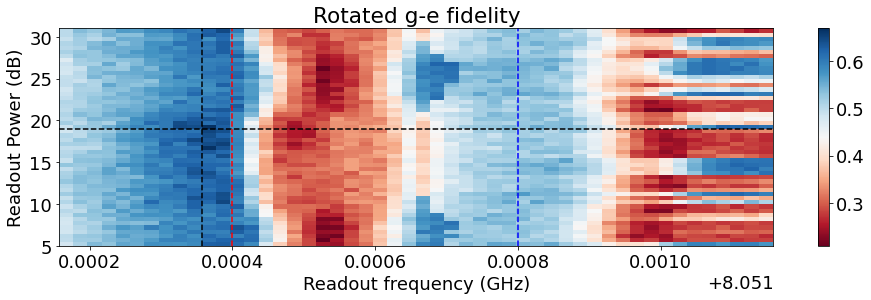

#############################################################################################
Optimal fidelity of 0.668563 at readout power = - 19.000000 dB and readout frequency = 8.051358 GHz
#############################################################################################


In [34]:
fid_power = []
"""The sweep occurs in the following order: for a fixed readout frequency, the power is swept
    and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
    one readout frequency.  
    """
avgs = 3000

for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
#         print(len(ig), len(qe))
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj::len(freqs)]
            b = qg.iloc[jj::len(freqs)]
            c = ie.iloc[jj::len(freqs)]
            d = qe.iloc[jj::len(freqs)]

            """Compute the medians of each blob"""
            
            xg, yg = np.median(a), np.median(b)
            xe, ye = np.median(c), np.median(d)
            
            """Compute the rotation angle"""
            theta = -arctan((ye-yg)/(xe-xg))
            """Rotate the IQ data"""
            ig_new = a*cos(theta) - b*sin(theta)
            qg_new = a*sin(theta) + b*cos(theta) 
            ie_new = c*cos(theta) - d*sin(theta)
            qe_new = c*sin(theta) + d*cos(theta)
#             print(len(ig_new), len(qe_new))

            """New means of each blob"""
            xg, yg = np.median(ig_new), np.median(qg_new)
            xe, ye = np.median(ie_new), np.median(qe_new)
            """X and Y ranges for histogram"""
            xlims = [xg-ran/5, xg+ran/5]
            ylims = [yg-ran/5, yg+ran/5]
#             plt.scatter(ig_new, qg_new, 'bo')
#             plt.scatter(ie_new, qe_new, 'ro')
            
            ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
            ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)
            """Compute the fidelity using overlap of the histograms"""
            fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
            fid_freq.append(fid)
        
        fid_power.append(fid_freq)   
"""Row number corresponding to maximum fidelity"""
# fid_power = np.transpose(fid_power)
ind = np.argmax(fid_power)
f_vec = freqs/1e9 + 0.5*(8.051828 + 8.051487)
plt.figure(figsize=(16, 4))
plt.pcolormesh(f_vec, attens, fid_power, cmap='RdBu')
plt.xlabel('Readout frequency (GHz)')
plt.ylabel('Readout Power (dB)')
plt.title('Rotated g-e fidelity')
plt.colorbar()
plt.axvline(x=f_vec[ind%len(freqs)], color='k', linestyle='--')
plt.axhline(y=attens[ind//len(freqs)], color='k', linestyle='--')
plt.axvline(x = 8.0514, color='r', linestyle='--')
plt.axvline(x = 8.0518, color='b', linestyle='--')
plt.show()

print("#############################################################################################")
print('Optimal fidelity of %f at readout power = - %f dB and readout frequency = %f GHz'%(np.max(fid_power), attens[ind//len(freqs)],f_vec[ind%len(freqs)] ))
print("#############################################################################################")

# ind = ind%len(freqs)*len(attens) + ind//len(freqs)

# ig_opt, qg_opt = Ig.iloc[ind], Qg.iloc[ind]
# ie_opt, qe_opt = Ie.iloc[ind], Qe.iloc[ind]


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.6, right=1.25, top=1.5)

# ax = axs[0, 0]
# ax.set_title('Unrotated')
# ax.scatter(ig_opt, qg_opt, label='g', alpha=0.25)
# ax.scatter(ie_opt, qe_opt, label='e', alpha=0.25)
# xg, yg = mean(ig_opt), mean(qg_opt)
# xe, ye = mean(ie_opt), mean(qe_opt)

# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)

# theta = -arctan((ye-yg)/(xe-xg))
# print("Rotation angle:   %.3f"%theta)

# ax = axs[0, 1]
# ax.set_title('Unrotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.legend(loc='best')
# ax.set_ylim(ylims[0], ylims[1])
# ax.set_xlim(xlims[0], xlims[1])


# ax = axs[1, 0]
# ax.set_title('Rotated')
# ig_new, qg_new = ig_opt*cos(theta)- qg_opt*sin(theta), ig_opt*sin(theta)+ qg_opt*cos(theta) 
# ie_new, qe_new = ie_opt*cos(theta)- qe_opt*sin(theta), ie_opt*sin(theta)+ qe_opt*cos(theta) 

# ax.scatter(ig_new, qg_new, label='g', alpha=0.25)
# ax.scatter(ie_new, qe_new, label='e', alpha=0.25)

# xg, yg = mean(ig_new), mean(qg_new)
# xe, ye = mean(ie_new), mean(qe_new)

# ax.errorbar(xg, yg, xerr=std(ig_new), yerr=std(qg_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_new), yerr=std(qe_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylim(ylims[0], ylims[1])

# ax.set_xlabel('I(V)')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)
# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])


# ax = axs[1, 1]
# ax.set_title('Rotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.set_xlabel('I(V)')
# ax.legend(loc='best')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims[0], ylims[1])
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.tight_layout()
# ax = axs[0, 0]
# ax.set_title('I')
# xlims = [xg-ran/5, xg+ran/5]
# ng, binsg, p = ax.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=[1, 0.01, 0.02, 1, 0.01, 0.0])
# ax.plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
# ax.text(xg, 50, "$\mu_{g}$ = %.4f \n $\sigma_{g}$ = %.5f"%(popt[1], popt[2]))
# ax.set_ylabel('# of counts')

# ne, binse, p = ax.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=[1, 0.01, -0.02, 1, 0.01, -0.01])
# ax.plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
# ax.text(xe, 150, "$\mu_{e}$ = %.4f \n $\sigma_{e}$ = %.5f"%(popt[4], popt[5]))
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax = axs[1, 0]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('I(V)')
# ax.set_ylabel('F')
# print("##################################################################################")
# print ("Single shot readout fidility from channel ", "I", " after rotation = ",fid)
# print ("Optimal angle =",theta)
# print("##################################################################################")

# ax = axs[0, 1]
# ax.set_title('Q')
# ylims  = [yg-ran/5, yg+ran/5]
# ng, binsg, p = ax.hist(qg_new, bins=numbins,range =ylims, color='b', label='g', alpha=0.5)
# ne, binse, p = ax.hist(qe_new, bins=numbins,range =ylims, color='r', label='e', alpha=0.5)
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax.set_xlabel('Q(V)')

# print ("Single shot readout fidility from channel ","Q"," after rotation = ",fid)
# ax = axs[1, 1]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('Q(V)')
# ax.set_ylabel('F')

# plt.show()

## 3us

In [24]:
filename = "C://_Lib/python//slab//experiments//qm_opx//data//histogram_amp_freq_sweep_100MHz_3us.h5"
numbins = 200
ran = 0.8
with File(filename,'r') as a:
        Ig = array(a['ig'])/ran
        Qg = array(a['qg'])/ran
        Ie = array(a['ie'])/ran
        Qe = array(a['qe'])/ran
        attens = array(a['att'])
        freqs = array(a['freq'])
        print(shape(Ig))
Ig = pd.DataFrame(Ig)
Qg = pd.DataFrame(Qg)
Ie = pd.DataFrame(Ie)
Qe = pd.DataFrame(Qe)

(3813000,)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


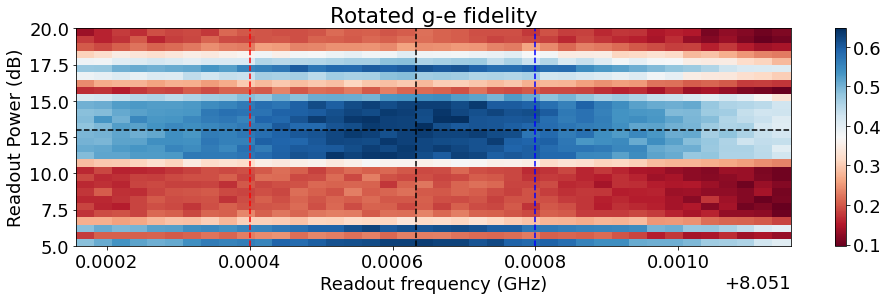

#############################################################################################
Optimal fidelity of 0.646667 at readout power = - 13.000000 dB and readout frequency = 8.051633 GHz
#############################################################################################


In [25]:
fid_power = []
"""The sweep occurs in the following order: for a fixed readout frequency, the power is swept
    and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
    one readout frequency.  
    """
avgs = 3000

for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
#         print(len(ig), len(qe))
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj::len(freqs)]
            b = qg.iloc[jj::len(freqs)]
            c = ie.iloc[jj::len(freqs)]
            d = qe.iloc[jj::len(freqs)]

            """Compute the medians of each blob"""
            
            xg, yg = np.median(a), np.median(b)
            xe, ye = np.median(c), np.median(d)
            
            """Compute the rotation angle"""
            theta = -arctan((ye-yg)/(xe-xg))
            """Rotate the IQ data"""
            ig_new = a*cos(theta) - b*sin(theta)
            qg_new = a*sin(theta) + b*cos(theta) 
            ie_new = c*cos(theta) - d*sin(theta)
            qe_new = c*sin(theta) + d*cos(theta)
#             print(len(ig_new), len(qe_new))

            """New means of each blob"""
            xg, yg = np.median(ig_new), np.median(qg_new)
            xe, ye = np.median(ie_new), np.median(qe_new)
            """X and Y ranges for histogram"""
            xlims = [xg-ran/5, xg+ran/5]
            ylims = [yg-ran/5, yg+ran/5]
#             plt.scatter(ig_new, qg_new, 'bo')
#             plt.scatter(ie_new, qe_new, 'ro')
            
            ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
            ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)
            """Compute the fidelity using overlap of the histograms"""
            fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
            fid_freq.append(fid)
        
        fid_power.append(fid_freq)   
"""Row number corresponding to maximum fidelity"""
# fid_power = np.transpose(fid_power)
ind = np.argmax(fid_power)
f_vec = freqs/1e9 + 0.5*(8.051828 + 8.051487)
plt.figure(figsize=(16, 4))
plt.pcolormesh(f_vec, attens, fid_power, cmap='RdBu')
plt.xlabel('Readout frequency (GHz)')
plt.ylabel('Readout Power (dB)')
plt.title('Rotated g-e fidelity')
plt.colorbar()
plt.axvline(x=f_vec[ind%len(freqs)], color='k', linestyle='--')
plt.axhline(y=attens[ind//len(freqs)], color='k', linestyle='--')
plt.axvline(x = 8.0514, color='r', linestyle='--')
plt.axvline(x = 8.0518, color='b', linestyle='--')
plt.show()

print("#############################################################################################")
print('Optimal fidelity of %f at readout power = - %f dB and readout frequency = %f GHz'%(np.max(fid_power), attens[ind//len(freqs)],f_vec[ind%len(freqs)] ))
print("#############################################################################################")

# ind = ind%len(freqs)*len(attens) + ind//len(freqs)

# ig_opt, qg_opt = Ig.iloc[ind], Qg.iloc[ind]
# ie_opt, qe_opt = Ie.iloc[ind], Qe.iloc[ind]


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.6, right=1.25, top=1.5)

# ax = axs[0, 0]
# ax.set_title('Unrotated')
# ax.scatter(ig_opt, qg_opt, label='g', alpha=0.25)
# ax.scatter(ie_opt, qe_opt, label='e', alpha=0.25)
# xg, yg = mean(ig_opt), mean(qg_opt)
# xe, ye = mean(ie_opt), mean(qe_opt)

# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)

# theta = -arctan((ye-yg)/(xe-xg))
# print("Rotation angle:   %.3f"%theta)

# ax = axs[0, 1]
# ax.set_title('Unrotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.legend(loc='best')
# ax.set_ylim(ylims[0], ylims[1])
# ax.set_xlim(xlims[0], xlims[1])


# ax = axs[1, 0]
# ax.set_title('Rotated')
# ig_new, qg_new = ig_opt*cos(theta)- qg_opt*sin(theta), ig_opt*sin(theta)+ qg_opt*cos(theta) 
# ie_new, qe_new = ie_opt*cos(theta)- qe_opt*sin(theta), ie_opt*sin(theta)+ qe_opt*cos(theta) 

# ax.scatter(ig_new, qg_new, label='g', alpha=0.25)
# ax.scatter(ie_new, qe_new, label='e', alpha=0.25)

# xg, yg = mean(ig_new), mean(qg_new)
# xe, ye = mean(ie_new), mean(qe_new)

# ax.errorbar(xg, yg, xerr=std(ig_new), yerr=std(qg_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_new), yerr=std(qe_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylim(ylims[0], ylims[1])

# ax.set_xlabel('I(V)')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)
# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])


# ax = axs[1, 1]
# ax.set_title('Rotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.set_xlabel('I(V)')
# ax.legend(loc='best')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims[0], ylims[1])
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.tight_layout()
# ax = axs[0, 0]
# ax.set_title('I')
# xlims = [xg-ran/5, xg+ran/5]
# ng, binsg, p = ax.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=[1, 0.01, 0.02, 1, 0.01, 0.0])
# ax.plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
# ax.text(xg, 50, "$\mu_{g}$ = %.4f \n $\sigma_{g}$ = %.5f"%(popt[1], popt[2]))
# ax.set_ylabel('# of counts')

# ne, binse, p = ax.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=[1, 0.01, -0.02, 1, 0.01, -0.01])
# ax.plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
# ax.text(xe, 150, "$\mu_{e}$ = %.4f \n $\sigma_{e}$ = %.5f"%(popt[4], popt[5]))
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax = axs[1, 0]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('I(V)')
# ax.set_ylabel('F')
# print("##################################################################################")
# print ("Single shot readout fidility from channel ", "I", " after rotation = ",fid)
# print ("Optimal angle =",theta)
# print("##################################################################################")

# ax = axs[0, 1]
# ax.set_title('Q')
# ylims  = [yg-ran/5, yg+ran/5]
# ng, binsg, p = ax.hist(qg_new, bins=numbins,range =ylims, color='b', label='g', alpha=0.5)
# ne, binse, p = ax.hist(qe_new, bins=numbins,range =ylims, color='r', label='e', alpha=0.5)
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax.set_xlabel('Q(V)')

# print ("Single shot readout fidility from channel ","Q"," after rotation = ",fid)
# ax = axs[1, 1]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('Q(V)')
# ax.set_ylabel('F')

# plt.show()

## 1us

In [35]:
filename = "C://_Lib/python//slab//experiments//qm_opx//data//histogram_amp_freq_sweep_100MHz_1us.h5"
numbins = 200
ran = 0.8
with File(filename,'r') as a:
        Ig = array(a['ig'])/ran
        Qg = array(a['qg'])/ran
        Ie = array(a['ie'])/ran
        Qe = array(a['qe'])/ran
        attens = array(a['att'])
        freqs = array(a['freq'])
        print(shape(Ig))
Ig = pd.DataFrame(Ig)
Qg = pd.DataFrame(Qg)
Ie = pd.DataFrame(Ie)
Qe = pd.DataFrame(Qe)

(891000,)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


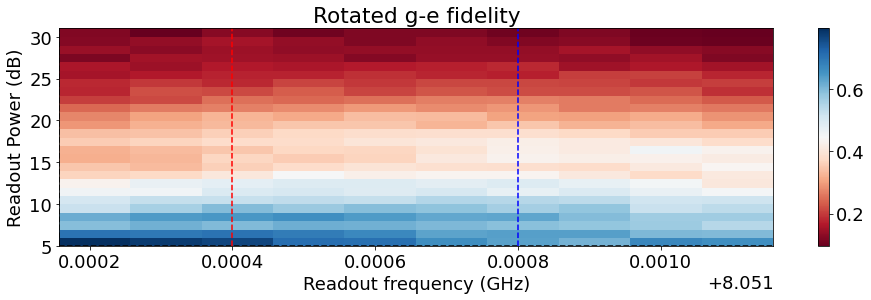

#############################################################################################
Optimal fidelity of 0.795667 at readout power = - 5.000000 dB and readout frequency = 8.051158 GHz
#############################################################################################


In [36]:
fid_power = []
"""The sweep occurs in the following order: for a fixed readout frequency, the power is swept
    and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
    one readout frequency.  
    """
avgs = 3000

for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
#         print(len(ig), len(qe))
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj::len(freqs)]
            b = qg.iloc[jj::len(freqs)]
            c = ie.iloc[jj::len(freqs)]
            d = qe.iloc[jj::len(freqs)]

            """Compute the medians of each blob"""
            
            xg, yg = np.median(a), np.median(b)
            xe, ye = np.median(c), np.median(d)
            
            """Compute the rotation angle"""
            theta = -arctan((ye-yg)/(xe-xg))
            """Rotate the IQ data"""
            ig_new = a*cos(theta) - b*sin(theta)
            qg_new = a*sin(theta) + b*cos(theta) 
            ie_new = c*cos(theta) - d*sin(theta)
            qe_new = c*sin(theta) + d*cos(theta)
#             print(len(ig_new), len(qe_new))

            """New means of each blob"""
            xg, yg = np.median(ig_new), np.median(qg_new)
            xe, ye = np.median(ie_new), np.median(qe_new)
            """X and Y ranges for histogram"""
            xlims = [xg-ran/5, xg+ran/5]
            ylims = [yg-ran/5, yg+ran/5]
#             plt.scatter(ig_new, qg_new, 'bo')
#             plt.scatter(ie_new, qe_new, 'ro')
            
            ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
            ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)
            """Compute the fidelity using overlap of the histograms"""
            fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
            fid_freq.append(fid)
        
        fid_power.append(fid_freq)   
"""Row number corresponding to maximum fidelity"""
# fid_power = np.transpose(fid_power)
ind = np.argmax(fid_power)
f_vec = freqs/1e9 + 0.5*(8.051828 + 8.051487)
plt.figure(figsize=(16, 4))
plt.pcolormesh(f_vec, attens, fid_power, cmap='RdBu')
plt.xlabel('Readout frequency (GHz)')
plt.ylabel('Readout Power (dB)')
plt.title('Rotated g-e fidelity')
plt.colorbar()
plt.axvline(x=f_vec[ind%len(freqs)], color='k', linestyle='--')
plt.axhline(y=attens[ind//len(freqs)], color='k', linestyle='--')
plt.axvline(x = 8.0514, color='r', linestyle='--')
plt.axvline(x = 8.0518, color='b', linestyle='--')
plt.show()

print("#############################################################################################")
print('Optimal fidelity of %f at readout power = - %f dB and readout frequency = %f GHz'%(np.max(fid_power), attens[ind//len(freqs)],f_vec[ind%len(freqs)] ))
print("#############################################################################################")

# ind = ind%len(freqs)*len(attens) + ind//len(freqs)

# ig_opt, qg_opt = Ig.iloc[ind], Qg.iloc[ind]
# ie_opt, qe_opt = Ie.iloc[ind], Qe.iloc[ind]


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.6, right=1.25, top=1.5)

# ax = axs[0, 0]
# ax.set_title('Unrotated')
# ax.scatter(ig_opt, qg_opt, label='g', alpha=0.25)
# ax.scatter(ie_opt, qe_opt, label='e', alpha=0.25)
# xg, yg = mean(ig_opt), mean(qg_opt)
# xe, ye = mean(ie_opt), mean(qe_opt)

# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)

# theta = -arctan((ye-yg)/(xe-xg))
# print("Rotation angle:   %.3f"%theta)

# ax = axs[0, 1]
# ax.set_title('Unrotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.legend(loc='best')
# ax.set_ylim(ylims[0], ylims[1])
# ax.set_xlim(xlims[0], xlims[1])


# ax = axs[1, 0]
# ax.set_title('Rotated')
# ig_new, qg_new = ig_opt*cos(theta)- qg_opt*sin(theta), ig_opt*sin(theta)+ qg_opt*cos(theta) 
# ie_new, qe_new = ie_opt*cos(theta)- qe_opt*sin(theta), ie_opt*sin(theta)+ qe_opt*cos(theta) 

# ax.scatter(ig_new, qg_new, label='g', alpha=0.25)
# ax.scatter(ie_new, qe_new, label='e', alpha=0.25)

# xg, yg = mean(ig_new), mean(qg_new)
# xe, ye = mean(ie_new), mean(qe_new)

# ax.errorbar(xg, yg, xerr=std(ig_new), yerr=std(qg_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_new), yerr=std(qe_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylim(ylims[0], ylims[1])

# ax.set_xlabel('I(V)')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)
# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])


# ax = axs[1, 1]
# ax.set_title('Rotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.set_xlabel('I(V)')
# ax.legend(loc='best')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims[0], ylims[1])
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.tight_layout()
# ax = axs[0, 0]
# ax.set_title('I')
# xlims = [xg-ran/5, xg+ran/5]
# ng, binsg, p = ax.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=[1, 0.01, 0.02, 1, 0.01, 0.0])
# ax.plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
# ax.text(xg, 50, "$\mu_{g}$ = %.4f \n $\sigma_{g}$ = %.5f"%(popt[1], popt[2]))
# ax.set_ylabel('# of counts')

# ne, binse, p = ax.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=[1, 0.01, -0.02, 1, 0.01, -0.01])
# ax.plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
# ax.text(xe, 150, "$\mu_{e}$ = %.4f \n $\sigma_{e}$ = %.5f"%(popt[4], popt[5]))
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax = axs[1, 0]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('I(V)')
# ax.set_ylabel('F')
# print("##################################################################################")
# print ("Single shot readout fidility from channel ", "I", " after rotation = ",fid)
# print ("Optimal angle =",theta)
# print("##################################################################################")

# ax = axs[0, 1]
# ax.set_title('Q')
# ylims  = [yg-ran/5, yg+ran/5]
# ng, binsg, p = ax.hist(qg_new, bins=numbins,range =ylims, color='b', label='g', alpha=0.5)
# ne, binse, p = ax.hist(qe_new, bins=numbins,range =ylims, color='r', label='e', alpha=0.5)
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax.set_xlabel('Q(V)')

# print ("Single shot readout fidility from channel ","Q"," after rotation = ",fid)
# ax = axs[1, 1]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('Q(V)')
# ax.set_ylabel('F')

# plt.show()

In [51]:
1-np.exp(-3.6/110)

0.03219753027224237

In [19]:
#FWHM of a Gaussian pulse
4*np.log10(2)/4

0.3010299956639812

In [21]:
32/np.sqrt(3.5*1e-3)

540.8987230262507

# 95 MHz IF

In [30]:
filename = "C://_Lib/python//slab//experiments//qm_opx//data//histogram_amp_freq_sweep_95MHz.h5"
numbins = 200
ran = 0.8
with File(filename,'r') as a:
        Ig = array(a['ig'])/ran
        Qg = array(a['qg'])/ran
        Ie = array(a['ie'])/ran
        Qe = array(a['qe'])/ran
        attens = array(a['att'])
        freqs = array(a['freq'])
        print(shape(Ig))
Ig = pd.DataFrame(Ig)
Qg = pd.DataFrame(Qg)
Ie = pd.DataFrame(Ie)
Qe = pd.DataFrame(Qe)

(2542000,)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


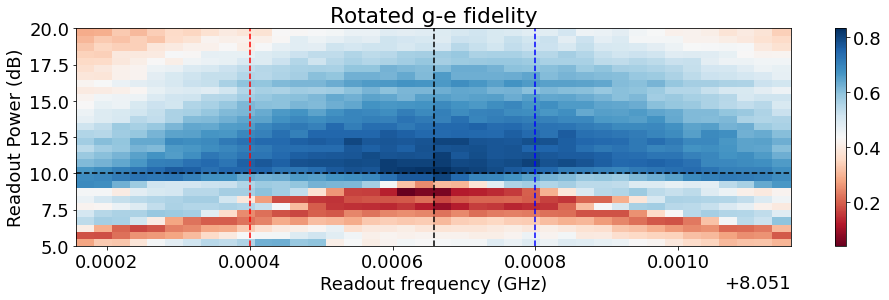

#############################################################################################
Optimal fidelity of 0.831539 at readout power = - 10.000000 dB and readout frequency = 8.051658 GHz
#############################################################################################


In [36]:
fid_power = []
"""The sweep occurs in the following order: for a fixed readout frequency, the power is swept
    and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
    one readout frequency.  
    """
avgs = 2000

for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
#         print(len(ig), len(qe))
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj::len(freqs)]
            b = qg.iloc[jj::len(freqs)]
            c = ie.iloc[jj::len(freqs)]
            d = qe.iloc[jj::len(freqs)]

            """Compute the medians of each blob"""
            
            xg, yg = np.median(a), np.median(b)
            xe, ye = np.median(c), np.median(d)
            
            """Compute the rotation angle"""
            theta = -arctan((ye-yg)/(xe-xg))
            """Rotate the IQ data"""
            ig_new = a*cos(theta) - b*sin(theta)
            qg_new = a*sin(theta) + b*cos(theta) 
            ie_new = c*cos(theta) - d*sin(theta)
            qe_new = c*sin(theta) + d*cos(theta)
#             print(len(ig_new), len(qe_new))

            """New means of each blob"""
            xg, yg = np.median(ig_new), np.median(qg_new)
            xe, ye = np.median(ie_new), np.median(qe_new)
            """X and Y ranges for histogram"""
            xlims = [xg-ran/5, xg+ran/5]
            ylims = [yg-ran/5, yg+ran/5]
#             plt.scatter(ig_new, qg_new, 'bo')
#             plt.scatter(ie_new, qe_new, 'ro')
            
            ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
            ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)
            """Compute the fidelity using overlap of the histograms"""
            fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()
            fid_freq.append(fid)
        
        fid_power.append(fid_freq)   
"""Row number corresponding to maximum fidelity"""
# fid_power = np.transpose(fid_power)
ind = np.argmax(fid_power)
f_vec = freqs/1e9 + 0.5*(8.051828 + 8.051487)
plt.figure(figsize=(16, 4))
plt.pcolormesh(f_vec, attens, fid_power, cmap='RdBu')
plt.xlabel('Readout frequency (GHz)')
plt.ylabel('Readout Power (dB)')
plt.title('Rotated g-e fidelity')
plt.colorbar()
plt.axvline(x=f_vec[ind%len(freqs)], color='k', linestyle='--')
plt.axhline(y=attens[ind//len(freqs)], color='k', linestyle='--')
plt.axvline(x = 8.0514, color='r', linestyle='--')
plt.axvline(x = 8.0518, color='b', linestyle='--')
plt.show()

print("#############################################################################################")
print('Optimal fidelity of %f at readout power = - %f dB and readout frequency = %f GHz'%(np.max(fid_power), attens[ind//len(freqs)],f_vec[ind%len(freqs)] ))
print("#############################################################################################")

# ind = ind%len(freqs)*len(attens) + ind//len(freqs)

# ig_opt, qg_opt = Ig.iloc[ind], Qg.iloc[ind]
# ie_opt, qe_opt = Ie.iloc[ind], Qe.iloc[ind]


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.6, right=1.25, top=1.5)

# ax = axs[0, 0]
# ax.set_title('Unrotated')
# ax.scatter(ig_opt, qg_opt, label='g', alpha=0.25)
# ax.scatter(ie_opt, qe_opt, label='e', alpha=0.25)
# xg, yg = mean(ig_opt), mean(qg_opt)
# xe, ye = mean(ie_opt), mean(qe_opt)

# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)

# theta = -arctan((ye-yg)/(xe-xg))
# print("Rotation angle:   %.3f"%theta)

# ax = axs[0, 1]
# ax.set_title('Unrotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.legend(loc='best')
# ax.set_ylim(ylims[0], ylims[1])
# ax.set_xlim(xlims[0], xlims[1])


# ax = axs[1, 0]
# ax.set_title('Rotated')
# ig_new, qg_new = ig_opt*cos(theta)- qg_opt*sin(theta), ig_opt*sin(theta)+ qg_opt*cos(theta) 
# ie_new, qe_new = ie_opt*cos(theta)- qe_opt*sin(theta), ie_opt*sin(theta)+ qe_opt*cos(theta) 

# ax.scatter(ig_new, qg_new, label='g', alpha=0.25)
# ax.scatter(ie_new, qe_new, label='e', alpha=0.25)

# xg, yg = mean(ig_new), mean(qg_new)
# xe, ye = mean(ie_new), mean(qe_new)

# ax.errorbar(xg, yg, xerr=std(ig_new), yerr=std(qg_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.errorbar(xe, ye, xerr=std(ie_new), yerr=std(qe_new), fmt='o', capthick=4, 
#             markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c')
# ax.set_ylim(ylims[0], ylims[1])

# ax.set_xlabel('I(V)')
# ax.set_ylabel('Q(V)')
# ax.legend(loc='best', fontsize=16)
# xlims = [xg-ran/5, xg+ran/5]
# ax.set_xlim(xlims[0], xlims[1])
# ylims = [yg-ran/5, yg+ran/5]
# ax.set_ylim(ylims[0], ylims[1])


# ax = axs[1, 1]
# ax.set_title('Rotated')
# ax.scatter(xg, yg, label='g', color='b', alpha=0.25)
# ax.scatter(xe, ye, label='e', color='r', alpha=0.25)
# ax.errorbar(xg, yg, xerr=std(ig_opt), yerr=std(qg_opt), fmt='o', capthick=4, 
#             markerfacecolor='b', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.errorbar(xe, ye, xerr=std(ie_opt), yerr=std(qe_opt), fmt='o', capthick=4, 
#             markerfacecolor='r', markeredgecolor='k', ecolor='#003f5c', alpha=0.25)
# ax.set_xlabel('I(V)')
# ax.legend(loc='best')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims[0], ylims[1])
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.tight_layout()
# ax = axs[0, 0]
# ax.set_title('I')
# xlims = [xg-ran/5, xg+ran/5]
# ng, binsg, p = ax.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=[1, 0.01, 0.02, 1, 0.01, 0.0])
# ax.plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
# ax.text(xg, 50, "$\mu_{g}$ = %.4f \n $\sigma_{g}$ = %.5f"%(popt[1], popt[2]))
# ax.set_ylabel('# of counts')

# ne, binse, p = ax.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
# popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=[1, 0.01, -0.02, 1, 0.01, -0.01])
# ax.plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
# ax.text(xe, 150, "$\mu_{e}$ = %.4f \n $\sigma_{e}$ = %.5f"%(popt[4], popt[5]))
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax = axs[1, 0]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('I(V)')
# ax.set_ylabel('F')
# print("##################################################################################")
# print ("Single shot readout fidility from channel ", "I", " after rotation = ",fid)
# print ("Optimal angle =",theta)
# print("##################################################################################")

# ax = axs[0, 1]
# ax.set_title('Q')
# ylims  = [yg-ran/5, yg+ran/5]
# ng, binsg, p = ax.hist(qg_new, bins=numbins,range =ylims, color='b', label='g', alpha=0.5)
# ne, binse, p = ax.hist(qe_new, bins=numbins,range =ylims, color='r', label='e', alpha=0.5)
# fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / ng.sum())).max()
# ax.legend(loc='best')
# ax.set_xlabel('Q(V)')

# print ("Single shot readout fidility from channel ","Q"," after rotation = ",fid)
# ax = axs[1, 1]
# ax.plot(binse[:-1],cumsum(ng)/ng.sum(),color='r')
# ax.plot(binse[:-1],cumsum(ne)/ng.sum(),color='b')
# ax.plot(binse[:-1],np.abs(cumsum(ne)-cumsum(ng))/ng.sum(),color='k')
# ax.set_xlabel('Q(V)')
# ax.set_ylabel('F')

# plt.show()

In [32]:
np.max(fid_power)

0.8315394242803504